# TTI sinusoid hill

This notebook demonstrates the application of immersed boundaries to a set of pseudo-acoustic wave equations featuring TTI. This is based on the Fletcher et al. 2009 TTI formulation.

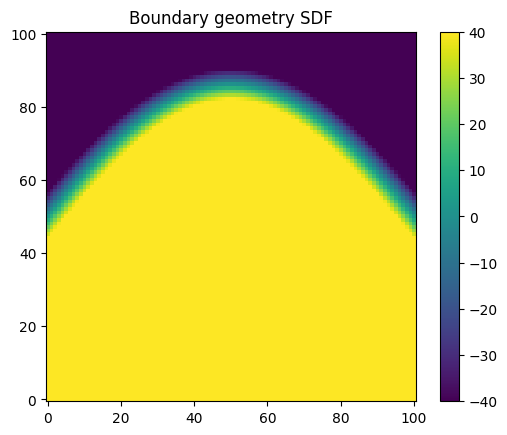

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)
q = dv.TimeFunction(name='q', grid=grid, space_order=s_o, time_order=2)

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),
           dv.Eq(p.dx2+p.dy2, 0),
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0),
           dv.Eq(q, 0),
           dv.Eq(q.dx2+q.dy2, 0),
           dv.Eq(q.dx4 + 2*q.dx2dy2 + q.dy4, 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
derivs = (p.dx2, p.dy2, p.dxdy, q.dx2, q.dy2, q.dxdy)
subs = boundary.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y), (x, 2))
Generating stencils for Derivative(p(t, x, y), (y, 2))
Generating stencils for Derivative(p(t, x, y), x, y)
Generating stencils for Derivative(q(t, x, y), (x, 2))
Generating stencils for Derivative(q(t, x, y), (y, 2))
Generating stencils for Derivative(q(t, x, y), x, y)


In [7]:
from examples.seismic import TimeAxis, RickerSource

v_py = 1.

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.6 seconds (600 ms)
dt = 0.5*10/v_py  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

In [8]:
import numpy as np
import sympy as sp

ep = dv.Function(name='epsilon', grid=grid)
de = dv.Function(name='delta', grid=grid)
th = dv.Function(name='theta', grid=grid)
th.data[:] = np.radians(45.)
de.data[:] = 0.1
ep.data[:] = 0.25
sig = 0.5  # Sigma parameter to control pseudoshear

v_pn = v_py*dv.sqrt(1+2*de)
v_px = v_py*dv.sqrt(1+2*ep)
v_sy = dv.sqrt(v_py**2*(ep-de)/sig)


# Define H1 and H2
def h1(f, th):
    """Return the H1 operator"""
    term1 = sp.sin(th)**2*f.dx2
    term2 = sp.cos(th)**2*f.dy2
    term3 = sp.sin(2*th)*f.dxdy
    return term1 + term2 + term3

def h2(f, th):
    """Return the H2 operator"""
    return f.dx2 + f.dy2 - h1(f, th)

# Define RHS expressions
rhs_p = v_px**2*h2(p, th) + v_py**2*h1(q, th) + v_sy**2*h1(p, th) - v_sy**2*h1(q, th)
rhs_q = v_pn**2*h2(p, th) + v_py**2*h1(q, th) - v_sy**2*h2(p, th) + v_sy**2*h2(q, th)

eq_p = dv.Eq(p.forward,
             2*p - p.backward
             + dt**2*rhs_p.subs(subs))

eq_q = dv.Eq(q.forward,
             2*q - q.backward
             + dt**2*rhs_q.subs(subs))

In [9]:
src_p = src.inject(field=p.forward, expr=src*dt**2)
src_q = src.inject(field=q.forward, expr=src*dt**2)

In [10]:
op = dv.Operator([eq_p, eq_q] + src_p + src_q)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.28 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0012079999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.27476999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=5.499999999999997e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

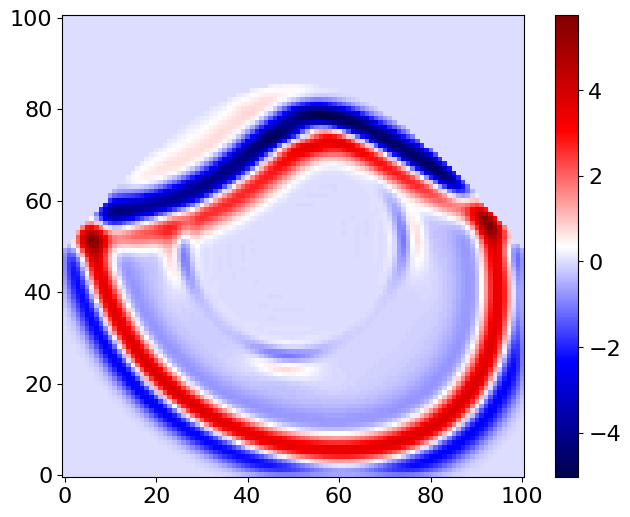

In [11]:
plt.imshow(p.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [12]:
assert np.isclose(np.linalg.norm(p.data), 230.2496)
assert np.isclose(np.linalg.norm(q.data), 205.35196)